In [834]:
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

In [835]:
batch_size = 128
image_size = (64, 64)
norm_denorm = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [836]:
transform_data = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root="data",
                                     transform=transform_data)

In [837]:
print(len(train_data))

8683


In [838]:
 class Discriminator(torch.nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            
            self.net = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=4, stride = 2, padding=1, bias = False),
                                           torch.nn.BatchNorm2d(64),
                                           torch.nn.LeakyReLU(0.2, inplace=True),
                                           
                                           torch.nn.Conv2d(64, 128, kernel_size=4, stride = 2, padding=1, bias = False),
                                           torch.nn.BatchNorm2d(128),
                                           torch.nn.LeakyReLU(0.2, inplace=True),
                                           
                                           torch.nn.Conv2d(128, 256, kernel_size=4, stride = 2, padding=1, bias = False),
                                           torch.nn.BatchNorm2d(256),
                                           torch.nn.LeakyReLU(0.2, inplace=True),
                                           
                                           torch.nn.Conv2d(256, 512, kernel_size=4, stride = 2, padding=1, bias = False),
                                           torch.nn.BatchNorm2d(512),
                                           torch.nn.LeakyReLU(0.2, inplace=True),
                                           
                                           torch.nn.Conv2d(512, 1, kernel_size=4, stride = 1, padding=0, bias = False),
                                           
                                           torch.nn.Flatten(),
                                           torch.nn.Sigmoid())
            
        def forward(self, x):
            x = self.net(x)
            return x
                                           

In [839]:
 class Generator(torch.nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.net = torch.nn.Sequential(torch.nn.ConvTranspose2d(150, 512, kernel_size=4, stride = 1, padding=0, bias = False),
                                           torch.nn.BatchNorm2d(512),
                                           torch.nn.ReLU(True),
                                           
                                           torch.nn.ConvTranspose2d(512, 256, kernel_size=4, stride = 2, padding=1, bias = False),
                                           torch.nn.BatchNorm2d(256),
                                           torch.nn.ReLU(True),
                                           
                                           torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride = 2, padding=1, bias = False),
                                           torch.nn.BatchNorm2d(128),
                                           torch.nn.ReLU(True),
                                           
                                           torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride = 2, padding=1, bias = False),
                                           torch.nn.BatchNorm2d(64),
                                           torch.nn.ReLU(True),
                                           
                                           torch.nn.ConvTranspose2d(64, 3, kernel_size=4, stride = 2, padding=1, bias = False),
                                           
                                           torch.nn.Tanh())
            
        def forward(self, x):
            x = self.net(x)
            return x

In [840]:
#!g1.1
def train_disc(optim_disc, real_img):
    optim_disc.zero_grad()
    true_logits = conv_disc(real_img)
    true_loss =  torch.nn.functional.binary_cross_entropy(true_logits, torch.ones_like(true_logits))
    
    z = torch.randn(128, 150, 1, 1).cuda()
    fake_img = conv_gen(z)
    fake_logits = conv_disc(fake_img)
    fake_loss = torch.nn.functional.binary_cross_entropy(fake_logits, torch.zeros_like(fake_logits))
    
    total_loss = true_loss + fake_loss
    total_loss.backward()
    optim_disc.step()
    return total_loss.item()

In [841]:
#!g1.1
def train_gen(optim_gen):
    optim_gen.zero_grad()
    z = torch.randn(128, 150, 1, 1).cuda()
    fake_img = conv_gen(z)
    
    fake_logits = conv_disc(fake_img)
    gen_loss = torch.nn.functional.binary_cross_entropy(fake_logits, torch.ones_like(fake_logits))
    
    gen_loss.backward()
    optim_gen.step()
    return gen_loss.item()

In [888]:
#!g1.1
from torchvision.utils import make_grid
def show_images():
    z = torch.randn(36, 150, 1, 1).cuda()
    generated_images = conv_gen(z).detach().cpu()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid((generated_images.detach()) * norm_denorm[1][0] + norm_denorm[0][0], nrow=6).permute(1, 2, 0))

In [843]:
#!g1.1
from torchvision.utils import save_image
import os

def saving_results(id_num):
    z = torch.randn(64, 150, 1, 1).cuda()
    generated_images = conv_gen(z).detach().cpu()
    generated_name = 'generated_images_{0:0=4d}.png'.format(id_num)
    directory = 'Generated_imgs'
    for_save = generated_images.detach() * norm_denorm[1][0] + norm_denorm[0][0]
    save_image(for_save, os.path.join(directory, generated_name), nrow=8)
    print('Saved:', generated_name)

In [844]:
#!g1.1
conv_gen = Generator().cuda()
conv_disc = Discriminator().cuda()

optim_gen = torch.optim.Adam(conv_gen.parameters(), lr=1e-3, betas=(0.5, 0.999))
optim_disc = torch.optim.Adam(conv_disc.parameters(), lr=1e-3, betas=(0.5, 0.999))

loader = DataLoader(train_data, batch_size, shuffle=True)

In [845]:
#!g1.1


In [846]:
#!g1.1
from IPython.display import clear_output
from tqdm.notebook import tqdm

d_losses, g_losses = [], []
extra_d_loss = 0
extra_g_loss = 0
counter = 0

for epoch in range(205):
  conv_gen.train()
  flag = 0
  for x_real,_ in tqdm(loader):

        d_loss = train_disc(optim_disc, x_real.cuda())
        g_loss = train_gen(optim_gen)
        
        extra_d_loss += d_loss
        extra_g_loss += g_loss
        counter += 1
        
        
    
  if epoch % 1 == 0 and flag == 0:
        #clear_output(True)
        print('Epoch:', epoch)
        print('D_loss:', extra_d_loss/counter)
        print('G_loss:', extra_g_loss/counter)
        conv_gen.eval()
    
        d_losses.append(extra_d_loss/counter)
        g_losses.append(extra_g_loss/counter)
        extra_d_loss = 0
        extra_g_loss = 0
        counter = 0
        flag = 1





Epoch: 0
D_loss: 1.2433634144801866
G_loss: 5.281279597212286



Epoch: 1
D_loss: 1.1643816635889166
G_loss: 2.194051534813993



Epoch: 2
D_loss: 1.227235973757856
G_loss: 2.140212541117388



Epoch: 3
D_loss: 1.199054471710149
G_loss: 2.1061993364025566



Epoch: 4
D_loss: 1.282330928479924
G_loss: 2.1038710238302456



Epoch: 5
D_loss: 1.1582091082544888
G_loss: 2.0621024317601147



Epoch: 6
D_loss: 1.2029350680463455
G_loss: 2.230469189145986



Epoch: 7
D_loss: 1.1506813019514084
G_loss: 2.48876489611233



Epoch: 8
D_loss: 1.1177062024088467
G_loss: 2.567191470195265



Epoch: 9
D_loss: 1.1781977099530838
G_loss: 2.5075161895331215



Epoch: 10
D_loss: 1.0138905008926111
G_loss: 3.127967028056874



Epoch: 11
D_loss: 1.036849599550752
G_loss: 2.850171834230423



Epoch: 12
D_loss: 1.0993365715531742
G_loss: 2.64618875524577



Epoch: 13
D_loss: 1.065774674362996
G_loss: 2.9790918669279884



Epoch: 14
D_loss: 1.0157280752764029
G_loss: 3.0145247210474575



Epoch: 15
D_loss: 1.0127085618236487
G_loss: 3.3102877420537613



Epoch: 16
D_loss: 1.0131719340296352
G_loss: 3.0109052263638554



Epoch: 17
D_loss: 0.990139397628167
G_loss: 3.105998854865046



Epoch: 18
D_loss: 0.9887107750948738
G_loss: 3.5143020661438213



Epoch: 19
D_loss: 0.9322498659877216
G_loss: 3.0776891357758465



Epoch: 20
D_loss: 0.9525641978663557
G_loss: 3.299703855724896



Epoch: 21
D_loss: 0.9800039446529221
G_loss: 3.547471167410121



Epoch: 22
D_loss: 0.919991580878987
G_loss: 3.3343479107407963



Epoch: 23
D_loss: 0.9146219250910422
G_loss: 3.259683319750954



Epoch: 24
D_loss: 0.9711060278555926
G_loss: 3.6683470913592506



Epoch: 25
D_loss: 0.9413838189314393
G_loss: 3.2551116434966816



Epoch: 26
D_loss: 0.9136359980877709
G_loss: 3.4903062126215767



Epoch: 27
D_loss: 0.9326805419781629
G_loss: 3.889544619356885



Epoch: 28
D_loss: 0.8606137861223782
G_loss: 3.483488083762281



Epoch: 29
D_loss: 0.8863949153353187
G_loss: 3.495950915357646



Epoch: 30
D_loss: 0.8536917738178197
G_loss: 3.7363150540520165



Epoch: 31
D_loss: 0.8941077502334819
G_loss: 3.42772377326208



Epoch: 32
D_loss: 0.8617470882394734
G_loss: 3.6094435979338253



Epoch: 33
D_loss: 0.8390101891230134
G_loss: 3.907395222607781



Epoch: 34
D_loss: 0.8555650903898127
G_loss: 3.4242159724235535



Epoch: 35
D_loss: 0.7905098589904168
G_loss: 3.515825718641281



Epoch: 36
D_loss: 0.8913436111281899
G_loss: 3.1141943554667866



Epoch: 37
D_loss: 0.7723944493952919
G_loss: 3.4355898709858166



Epoch: 38
D_loss: 0.9195975293131435
G_loss: 3.5318644169498894



Epoch: 39
D_loss: 0.9029824146453072
G_loss: 3.259180371375645



Epoch: 40
D_loss: 0.8476181696442997
G_loss: 3.109886488493751



Epoch: 41
D_loss: 0.8820015003575998
G_loss: 3.0439577996730804



Epoch: 42
D_loss: 0.8758792982381933
G_loss: 3.031965755364474



Epoch: 43
D_loss: 0.8860337576445412
G_loss: 2.9072860733551136



Epoch: 44
D_loss: 0.9034681293894263
G_loss: 2.991122783983455



Epoch: 45
D_loss: 0.840536014560391
G_loss: 3.078002040877062



Epoch: 46
D_loss: 0.8457237990463481
G_loss: 2.942598168464268



Epoch: 47
D_loss: 0.8408143564182169
G_loss: 3.3128716857994305

Epoch: 48
D_loss: 0.7899669360588578
G_loss: 3.232313163140241



Epoch: 49
D_loss: 0.8567766959176344
G_loss: 3.2304095345384933



Epoch: 50
D_loss: 0.8177167825839099
G_loss: 3.0799453933449352



Epoch: 51
D_loss: 0.8498406673178953
G_loss: 3.1626183736850235



Epoch: 52
D_loss: 0.7576106550062404
G_loss: 3.138670637327082



Epoch: 53
D_loss: 0.8706608142922906
G_loss: 3.167174639070735



Epoch: 54
D_loss: 0.7822092385853038
G_loss: 3.263764903825872



Epoch: 55
D_loss: 0.7816274078453288
G_loss: 3.1294847113244675



Epoch: 56
D_loss: 0.7269545736558297
G_loss: 3.2606801741263447



Epoch: 57
D_loss: 0.8101187861141037
G_loss: 3.0477119561503914



Epoch: 58
D_loss: 0.7888189830324229
G_loss: 3.354727769160972



Epoch: 59
D_loss: 0.67564746868961
G_loss: 3.5213555343010845



Epoch: 60
D_loss: 0.7525562398573932
G_loss: 3.225361836964593



Epoch: 61
D_loss: 0.7083951659938869
G_loss: 3.146171078962438



Epoch: 62
D_loss: 0.7206640712478581
G_loss: 3.2799513953573562



Epoch: 63
D_loss: 0.7039372180314625
G_loss: 3.3198852013139164



Epoch: 64
D_loss: 0.6398567710729206
G_loss: 3.44300040602684



Epoch: 65
D_loss: 0.6916693488464636
G_loss: 3.2195278572685577



Epoch: 66
D_loss: 0.6409756234463524
G_loss: 3.3437456400955425



Epoch: 67
D_loss: 0.750917552586864
G_loss: 3.395818714709843



Epoch: 68
D_loss: 0.5771314063492943
G_loss: 3.2349428744877087



Epoch: 69
D_loss: 0.5401114992359105
G_loss: 3.410436213893049



Epoch: 70
D_loss: 0.6066206040627816
G_loss: 3.445703850072973



Epoch: 71
D_loss: 0.5520795371164294
G_loss: 3.399711111012627



Epoch: 72
D_loss: 0.5551987154518857
G_loss: 3.6703125597799526



Epoch: 73
D_loss: 0.6802635997095529
G_loss: 3.5827520104015576



Epoch: 74
D_loss: 0.6066041358691805
G_loss: 3.46214718152495



Epoch: 75
D_loss: 0.4895406268975314
G_loss: 3.4973502229241764



Epoch: 76
D_loss: 0.46862703627523256
G_loss: 3.610102856860441



Epoch: 77
D_loss: 0.5530009552398149
G_loss: 3.6011282600024166



Epoch: 78
D_loss: 0.6575201701591996
G_loss: 3.781974031644709



Epoch: 79
D_loss: 0.43052249116932645
G_loss: 3.504021530642229



Epoch: 80
D_loss: 0.40818244416047544
G_loss: 3.5959397554397583



Epoch: 81
D_loss: 0.7474696704131716
G_loss: 3.6855630690560623



Epoch: 82
D_loss: 0.3862208081957172
G_loss: 3.5734696949229523



Epoch: 83
D_loss: 0.3210754462463014
G_loss: 3.867489085477941



Epoch: 84
D_loss: 0.3592025742811315
G_loss: 4.046368455185609



Epoch: 85
D_loss: 0.4081438743673703
G_loss: 4.258122225894647



Epoch: 86
D_loss: 0.4755987144787522
G_loss: 4.083856950787937



Epoch: 87
D_loss: 0.44408940512906103
G_loss: 4.029303342103958



Epoch: 88
D_loss: 0.27696618799339323
G_loss: 4.114651406512541



Epoch: 89
D_loss: 0.7290704164873151
G_loss: 4.250412145519958



Epoch: 90
D_loss: 0.3427765422007617
G_loss: 3.94122972909142



Epoch: 91
D_loss: 0.3851460057365544
G_loss: 4.198804136584787



Epoch: 92
D_loss: 0.26270801059025173
G_loss: 4.238551678026424



Epoch: 93
D_loss: 0.25162397856440616
G_loss: 4.398309875937069



Epoch: 94
D_loss: 0.30996524389175806
G_loss: 4.565617066972396



Epoch: 95
D_loss: 0.24564259795143323
G_loss: 4.427175462245941



Epoch: 96
D_loss: 1.2309225407045554
G_loss: 4.4175822195761345



Epoch: 97
D_loss: 0.8538060604649431
G_loss: 3.118220213581534



Epoch: 98
D_loss: 0.35087664315805717
G_loss: 3.7911894531810986



Epoch: 99
D_loss: 0.2578474686426275
G_loss: 3.922549349420211



Epoch: 100
D_loss: 0.2299735754290048
G_loss: 4.194755827679353



Epoch: 101
D_loss: 0.19231278438340216
G_loss: 4.412863173905541



Epoch: 102
D_loss: 0.21269073123660157
G_loss: 4.566440217635211



Epoch: 103
D_loss: 0.2701627344221753
G_loss: 4.856967663063722



Epoch: 104
D_loss: 0.26279238403281746
G_loss: 4.885228465585148



Epoch: 105
D_loss: 0.22400018222191753
G_loss: 4.877048467888551



Epoch: 106
D_loss: 0.19387810156844995
G_loss: 4.780604560585583



Epoch: 107
D_loss: 0.3317549829097355
G_loss: 5.18225686339771



Epoch: 108
D_loss: 0.26725653964368734
G_loss: 5.207379793419557



Epoch: 109
D_loss: 0.27495055114302563
G_loss: 5.187448848696316



Epoch: 110
D_loss: 0.1781142933622879
G_loss: 5.195755849866306



Epoch: 111
D_loss: 0.19242968963568702
G_loss: 5.168854783563053



Epoch: 112
D_loss: 0.1635801294708953
G_loss: 5.45353694523082



Epoch: 113
D_loss: 0.1363292030770989
G_loss: 5.370530437020695



Epoch: 114
D_loss: 0.12751253784688957
G_loss: 5.4589757007711075



Epoch: 115
D_loss: 2.3138725280433015
G_loss: 3.1103482810123



Epoch: 116
D_loss: 0.8147502909688389
G_loss: 3.7294262016520783



Epoch: 117
D_loss: 0.3981446799109964
G_loss: 4.3889595988918755



Epoch: 118
D_loss: 0.23016247032758066
G_loss: 4.493420933975893



Epoch: 119
D_loss: 0.18265123742029948
G_loss: 4.5625303878503685



Epoch: 120
D_loss: 0.1446443152449587
G_loss: 4.863497481626623



Epoch: 121
D_loss: 0.1481615755816593
G_loss: 4.968071376576143



Epoch: 122
D_loss: 0.20067719898789244
G_loss: 5.31959477592917



Epoch: 123
D_loss: 0.5447732584879679
G_loss: 5.283552111948238



Epoch: 124
D_loss: 0.3446608238360461
G_loss: 5.080945355050704



Epoch: 125
D_loss: 0.14744969944962683
G_loss: 5.189663052558899



Epoch: 126
D_loss: 0.11450271730256431
G_loss: 5.159270567052505



Epoch: 127
D_loss: 0.10400951511281378
G_loss: 5.3623616520096276



Epoch: 128
D_loss: 0.1447316264898023
G_loss: 5.62553215377471



Epoch: 129
D_loss: 0.10982503057183589
G_loss: 5.533768369871027



Epoch: 130
D_loss: 0.12205060538561906
G_loss: 5.740367794738097



Epoch: 131
D_loss: 0.6908589936518932
G_loss: 5.526165087433422



Epoch: 132
D_loss: 0.5113482269294122
G_loss: 5.065321045763352



Epoch: 133
D_loss: 0.18721749611637173
G_loss: 5.2877932751879975



Epoch: 134
D_loss: 0.12026496888960109
G_loss: 5.292293597670162



Epoch: 135
D_loss: 0.11631814174025375
G_loss: 5.5012567709474



Epoch: 136
D_loss: 0.1344345209243543
G_loss: 5.694175601005554



Epoch: 137
D_loss: 0.09226111703387954
G_loss: 5.660980634829578



Epoch: 138
D_loss: 0.5623712600208819
G_loss: 5.937771968981799



Epoch: 139
D_loss: 0.21022654039894834
G_loss: 5.504763641778161



Epoch: 140
D_loss: 0.12338185965028756
G_loss: 5.610086500644684



Epoch: 141
D_loss: 0.11073152627795935
G_loss: 5.9689609864178825



Epoch: 142
D_loss: 0.07501736272345572
G_loss: 5.97168669981115



Epoch: 143
D_loss: 0.07728432043565109
G_loss: 5.972013729460099



Epoch: 144
D_loss: 0.9238966102164019
G_loss: 5.982984430649701



Epoch: 145
D_loss: 0.2423252896131838
G_loss: 5.496165598140044



Epoch: 146
D_loss: 0.12161675851572962
G_loss: 5.5550380699774795



Epoch: 147
D_loss: 0.09076087456196547
G_loss: 5.515815994318793



Epoch: 148
D_loss: 0.08264129244558074
G_loss: 5.840724345515756



Epoch: 149
D_loss: 0.08804140500176479
G_loss: 6.06858388115378



Epoch: 150
D_loss: 0.1372584538972553
G_loss: 6.334771426285014



Epoch: 151
D_loss: 0.3943378253127722
G_loss: 6.11044624097207



Epoch: 152
D_loss: 0.12529000883702845
G_loss: 5.953717291355133



Epoch: 153
D_loss: 0.08297458089723744
G_loss: 6.177941715016084



Epoch: 154
D_loss: 0.0723313423257102
G_loss: 6.195693668197183



Epoch: 155
D_loss: 0.07855944861384
G_loss: 6.584854560739854



Epoch: 156
D_loss: 0.14267616428653984
G_loss: 6.943723506787244



Epoch: 157
D_loss: 0.09981178721029531
G_loss: 6.843472943586462



Epoch: 158
D_loss: 0.06107707466820583
G_loss: 6.666486144065857



Epoch: 159
D_loss: 0.07782213696662117
G_loss: 6.889890253543854



Epoch: 160
D_loss: 0.08790606378084596
G_loss: 6.852829126750722



Epoch: 161
D_loss: 0.0800578467657461
G_loss: 6.952212203951443



Epoch: 162
D_loss: 0.07469203409410137
G_loss: 7.202115192132838



Epoch: 163
D_loss: 1.2710355444646932
G_loss: 6.616776908145232



Epoch: 164
D_loss: 0.34072341780890436
G_loss: 5.864239328047809



Epoch: 165
D_loss: 0.14748907193322391
G_loss: 5.887115061283112



Epoch: 166
D_loss: 0.10350320714881972
G_loss: 6.020183019778308



Epoch: 167
D_loss: 0.10410535813528388
G_loss: 6.238034143167384



Epoch: 168
D_loss: 0.07302100409972756
G_loss: 6.432824906180887



Epoch: 169
D_loss: 0.09326848873923368
G_loss: 6.452970504760742


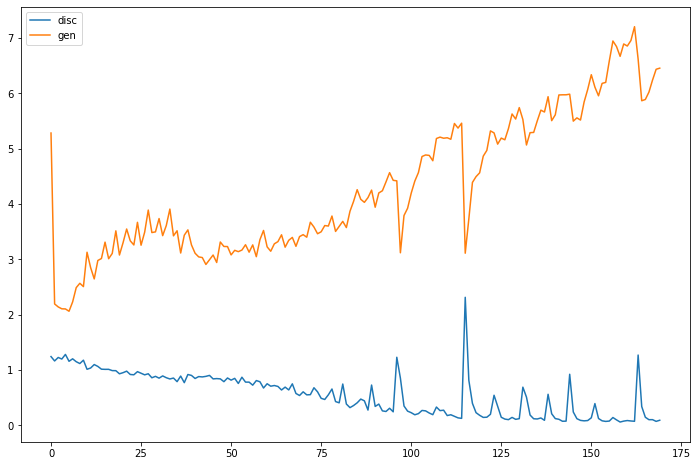

In [849]:
plt.figure(figsize=(12, 8))
plt.plot(d_losses, label="disc")
plt.plot(g_losses, label="gen")
plt.legend()
plt.show()

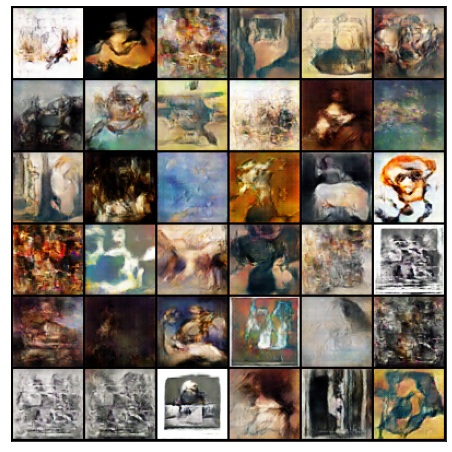

In [894]:
#!g1.1
show_images()

In [880]:
#!g1.1
#7

In [ ]:
#!g1.1
saving_results(id_num=4)